In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

### Os Dados de Chuva - INMET
#### Agrupando e Identificando localização Dados
Aqui, abriremos os dados baixados no site do inmet referentes aos anos de 2013 a 2022, inclusos. Cada arquivo contém, além dos dados de chuva, a localização da estação em latitude e longitude. 
As saídas do código abaixo serão
- Ind_Pluv.dataframe, que condensará o índice pluviométrico por estação (coluna) para os dez anos (linha)
- Loc.geodataframe, que conterá a localização das estações para que possamos, no futuro, correlacionar dado de chuva com posição e interpolar dados faltantes

In [2]:
Arq2 = os.listdir('./Data_2013_2022/')
Ind_Pluv = pd.DataFrame()

code = [] ; lat = [] ; long = []; cidade = []; uf = []; altitude = []
for folder in Arq2:
    try:
        Arq = os.listdir('./Data_2013_2022/'+folder)
        Aux = pd.DataFrame()
        
        code2 = []
        for file in Arq:
            _ = pd.read_csv('./Data_2013_2022/'+folder+'/'+file,sep=';',encoding="ISO-8859-1",nrows=6)
            cidade.append(_.iloc[1,1])
            uf.append(_.iloc[0,1])
            code.append(_.iloc[2,1])
            lat.append(_.iloc[3,1])
            long.append(_.iloc[4,1])
            altitude.append(_.iloc[5,1])

            code2.append(_.iloc[2,1])
        
        for i,file in enumerate(Arq):
            _ = pd.read_csv('./Data_2013_2022/'+folder+'/'+file,sep=';',encoding="ISO-8859-1",skiprows=8,decimal=',')
            Aux[code2[i]] = _['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] 

  
        Ind_Pluv = pd.concat([Ind_Pluv,Aux])
    
    except:
        None

Loc = pd.DataFrame()
Loc['Cidade'] = cidade
Loc['UF'] = uf
Loc['Código'] = code
Loc['Latitude'] = lat
Loc['Longitude'] = long
Loc['Altitude'] = altitude

/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_2663/245326985.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Aux[code2[i]] = _['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']
/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_2663/245326985.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Aux[code2[i]] = _['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']
/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_2663/245326985.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

In [3]:
#Trocando ',' por '.'
Loc = Loc.stack().str.replace(',','.').unstack() 

#Removendo dados Duplicados, por termos lido dados de
Loc = Loc.drop_duplicates(subset=['Código']) 
Ind_Pluv = (Ind_Pluv.T.drop_duplicates()).T

#Tornando Loc um geodf
Loc = gpd.GeoDataFrame( Loc, geometry=gpd.points_from_xy(Loc.Longitude, Loc.Latitude), crs="EPSG:4326" )

#Removendo Estações do Arquipélago de São Pedro e Paulo e da Antártida de Ind_Pluv e Loc
print(Loc.loc[ (Loc.Cidade == 'CRIOSFERA') | (Loc.Cidade =='ARQ.SAO PEDRO E SAO PAULO')  ])

rem_lst = Loc.loc[ (Loc.Cidade == 'CRIOSFERA') | (Loc.Cidade =='ARQ.SAO PEDRO E SAO PAULO')  ]['Código'].values
for codigo in rem_lst:
    del Ind_Pluv[codigo]

Loc = Loc.loc[ (Loc.Cidade != 'CRIOSFERA') & (Loc.Cidade != 'ARQ.SAO PEDRO E SAO PAULO')  ]

Loc

                         Cidade  UF Código Latitude     Longitude Altitude  \
267   ARQ.SAO PEDRO E SAO PAULO  RN   A302       .9  -29.31666666       15   
3316                  CRIOSFERA  SP   C891      -84  -79.49416666     1285   

                         geometry  
267     POINT (-29.31667 0.90000)  
3316  POINT (-79.49417 -84.00000)  


Cidade  UF Código      Latitude     Longitude  \
0                    ARCO VERDE  PE   A309   -8.41694443  -37.08333333   
1                      VENTANIA  PR   A872  -24.23833333  -50.24555555   
2                RONDON DO PARA  PA   A214   -4.82749999  -48.17333332   
3                        BALSAS  MA   A204   -7.45527777  -46.02749999   
4                       HUMAITA  AM   A112   -7.92277777  -63.12138888   
...                         ...  ..    ...           ...           ...   
2659                    CAMAPUA  MS   S707    -19.587528    -54.030083   
2660        SANTA RITA DO PARDO  MS   S716    -21.305889    -52.820375   
2665                    TIANGUA  CE   A368     -3.732169    -41.011881   
2799  SANTA MARIA DAS BARREIRAS  PA   A256   -8.72972221  -49.85638888   
2943                     POMPEU  MG   A560  -19.23249999  -44.96416666   

     Altitude                     geometry  
0       680.7   POINT (-37.08333 -8.41694)  
1        1106  POINT (-50.24556 -24.23833)  
2         203   POINT (-48.17333 -4.82750)  
3         254   POINT (-46.02750 -7.45528)  
4          72   POINT (-63.12139 -7.92278)  
...       ...                          ...  
2659      540  POINT (-54.03008 -19.58753)  
2660      383  POINT (-52.82037 -21.30589)  
2665      756   POINT (-41.01188 -3.73217)  
2799      165   POINT (-49.85639 -8.72972)  
2943      705  POINT (-44.96417 -19.23250)  

[611 rows x 7 columns]

#### Abrindo Mapa de Estados do Brasil e Plotando Localização Das Estações

In [4]:
UF = gpd.read_file('./2022/BR_UF_2022/BR_UF_2022.shp')

(-76.24759047174989, -26.590499411250004, -35.7023289475499, 7.222992030550026)

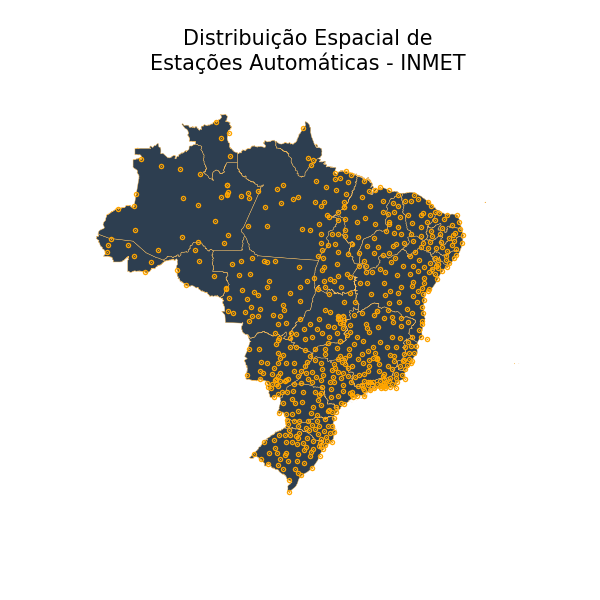

In [5]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(2, 2), dpi=300)

UF.plot(facecolor="#2D3E50", edgecolor="#FEBF57", ax=ax,lw=0.1)
Loc.plot(ax=ax, color='orange',markersize=0.1)

ax.set_title("Distribuição Espacial de\nEstações Automáticas - INMET", fontsize=5)
ax.axis("off")

### Limpando a Tabela de Chuvas - Ind_Pluv
A tabela de chuvas contém muitos valores negativos e NaNs que seram substituidos através de uma interpolação ponderada pelo inverso da dsitância. Para isso, vamos identificar as dez estaçõs vizinhas de cada estação e registrá-los em Loc.geodf

In [6]:
Ind_Pluv.head(3)

A309  A872  A214    A204  A112  A035  A215  A529  A535  A803  ...  A254  \
0   0.0   0.0   0.0 -9999.0   0.0   0.0   0.0   0.0   0.0   0.2  ...   NaN   
1   0.0   0.0   0.0 -9999.0   0.0   0.0   0.0   0.0   0.0   0.2  ...   NaN   
2   0.0   0.0   0.0 -9999.0   3.4   0.0   0.0   0.0   0.0  34.4  ...   NaN   

   A629  S706  A895  A377  S707  S716  A368  A256  A560  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[3 rows x 611 columns]

In [7]:
#Removendo valores negativos. Assumo-os como NaN para futura interpolação dos NaNs  
Ind_Pluv[Ind_Pluv < 0 ] = np.NAN

#Identificando os 10 vizinhos mais proximos
for i in np.arange( len(Loc) ):
    idx   = Loc.index[i]
    point = Loc.loc[ idx, 'geometry'  ]

    d = Loc.distance(point).values
    seq = np.argsort(d)
    
    for k in np.arange(10):
        Loc.loc[idx, f'Dis_{k+1}'] = d[seq[k+1]]
        Loc.loc[idx, f'Viz_{k+1}'] = Loc['Código'][Loc.index[k+1]]

Loc.sample(frac=1).head(3)

/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_2663/3958263967.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  d = Loc.distance(point).values
/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_2663/3958263967.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'A872' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Loc.loc[idx, f'Viz_{k+1}'] = Loc['Código'][Loc.index[k+1]]
/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_2663/3958263967.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'A214' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Loc.loc[idx, f'Viz_{k+1}'] = Loc['Código'][Loc.i

Cidade  UF Código      Latitude     Longitude Altitude  \
210  PORTO VELHO  RO   A925   -8.76388888  -63.47499999       98   
326       CALDAS  MG   A530  -21.91805554  -46.38305554     1150   
402       LABREA  AM   A111   -7.43527777   -64.7886111       64   

                        geometry     Dis_1 Viz_1     Dis_2  ...     Dis_6  \
210   POINT (-63.47500 -8.76389)  0.912419  A872  1.291298  ...  3.370137   
326  POINT (-46.38306 -21.91806)  0.498652  A872  0.652093  ...  1.085258   
402   POINT (-64.78861 -7.43528)  1.737034  A872  1.868363  ...  3.720390   

     Viz_6     Dis_7  Viz_7     Dis_8  Viz_8     Dis_9  Viz_9    Dis_10  \
210   A215  3.672589   A529  3.785947   A535  3.857243   A803  3.906454   
326   A215  1.140041   A529  1.199574   A535  1.245271   A803  1.280681   
402   A215  3.855697   A529  4.058585   A535  4.214618   A803  4.456576   

     Viz_10  
210    A126  
326    A126  
402    A126  

[3 rows x 27 columns]

#### Substintuindo NaNs de Ind_Pluv via interpolação

In [8]:
for m,j in enumerate( Ind_Pluv.columns ):
    #print(Loc.loc[ Loc['Código'] == j  ][f'Viz_{1}'])

    v = []
    d = []
    for k in np.arange(10):
        v.append( Loc.loc[ Loc['Código'] == j  ][f'Viz_{k+1}'].values[0] )
        d.append( Loc.loc[ Loc['Código'] == j  ][f'Dis_{k+1}'].values[0] )

    d = np.array(d)
    a = ( (Ind_Pluv[v]/(d**2)) /( (1/d**2).sum() ) ).sum(axis=1)

    Ind_Pluv[j] = Ind_Pluv[j].fillna( a )
#Esse procedimento deverá eliminar qualquer NaN contido no dataframe Ind_Pluv. 

### Proper Ortoghonal Decomposition

In [9]:
Chuva = np.zeros(( int(Ind_Pluv.shape[0]/24), int(Ind_Pluv.shape[1])  ))

aux = np.array(Ind_Pluv)

for i,r in enumerate(np.arange(0,len(Ind_Pluv),24)):
    Chuva[i,:] = aux[r:r+24,:].sum(axis=0) 


m = len(Chuva)
Chuva_desvio = Chuva - Chuva.mean(axis=0)

#Metodo mais simples
Cov = (1/(m-1))*np.dot( Chuva_desvio.T, Chuva_desvio)
Lambda, Phi = np.linalg.eig(Cov)

k = np.argsort(Lambda)[::-1] #Ordenando autovalores do maior para o menor 
Lambda = Lambda[k]
Phi = Phi[:,k]

A = np.dot(Chuva_desvio, Phi )

#As colunas de Phi sao os Modos POD
Modos = gpd.GeoDataFrame()
Modos['Código'] = Ind_Pluv.columns
for k in np.arange(6):
    Modos[f'Modo_{k+1}'] = np.real(Phi[:,k])

##### Plot dos Resultados 

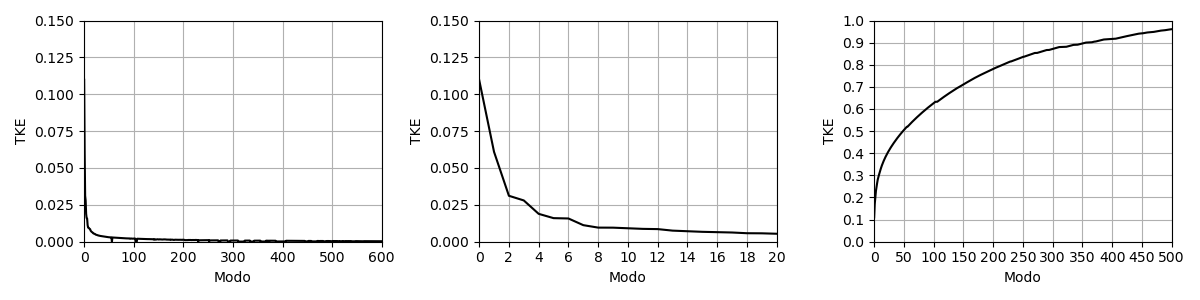

In [10]:
plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
plt.plot(Lambda/Lambda.sum(),'k')
plt.xticks(np.arange(0,901,100))
plt.xlim(0,600)

plt.yticks(np.arange(0,0.151,0.025))
plt.ylim(0,0.15)

plt.xlabel('Modo')
plt.ylabel('TKE')

plt.grid()
plt.tight_layout()

plt.subplot(1,3,2)
plt.plot(Lambda/Lambda.sum(),'k')
plt.xticks(np.arange(0,91,2))
plt.xlim(0,20)

plt.yticks(np.arange(0,0.151,0.025))
plt.ylim(0,0.15)

plt.xlabel('Modo')
plt.ylabel('TKE')

plt.grid()
plt.tight_layout()

plt.subplot(1,3,3)
plt.plot(np.cumsum(Lambda)/Lambda.sum(),'k')
plt.xticks(np.arange(0,501,50))
plt.xlim(0,500)

plt.yticks(np.arange(0,1.1,0.1))
plt.ylim(0,1)

plt.xlabel('Modo')
plt.ylabel('TKE')

plt.grid()
plt.tight_layout()

##### Registro dos Modos

In [27]:
Modos = gpd.GeoDataFrame()
Modos['Código'] = Ind_Pluv.columns
for k in np.arange(10):
    Modos[f'Modo_{k+1}'] = np.real(Phi[:,k])

### Associando cada Estação à sua respectiva Cidade
Cerca de 9% dos munícipios do páis possuem estação do Inmet. Para facilitar nossa visualização, vamos estender os dados registrados paras estações aos municípios que as contém. Mas onde conseguir os mapas dos municípios? No site do IBGE há dados sobre os limites dos municípios no formato shapefile (shp), adequado para a construção de mapas. 

In [28]:
Cidades = gpd.read_file('./2022/BR_Municipios_2022/BR_Municipios_2022.shp')
Cidades["centroid"] = Cidades["geometry"].centroid
Cidades.head(3)

/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_2663/2762269273.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Cidades["centroid"] = Cidades["geometry"].centroid


CD_MUN                 NM_MUN SIGLA_UF  AREA_KM2  \
0  1100015  Alta Floresta D'Oeste       RO  7067.127   
1  1100023              Ariquemes       RO  4426.571   
2  1100031                 Cabixi       RO  1314.352   

                                            geometry  \
0  POLYGON ((-62.00806 -12.13379, -62.00784 -12.2...   
1  POLYGON ((-63.17933 -10.13924, -63.17746 -10.1...   
2  POLYGON ((-60.52408 -13.32137, -60.37162 -13.3...   

                      centroid  
0  POINT (-62.27466 -12.47013)  
1   POINT (-62.95726 -9.95189)  
2  POINT (-60.63981 -13.47488)

#### Cruzando Código Com Município

In [32]:
for k in np.arange(6):
    Cidades[f'Modo_{k+1}'] = np.NAN

for indice in range(Cidades.shape[0]-1):

    pip = Loc.within(Cidades.loc[indice, 'geometry'])
    
    if pip.sum() > 0: 
        i = Loc.loc[pip, 'Código']
        for k in np.arange(len(Modos.columns) - 1):
            try:
                Cidades.loc[indice, f'Modo_{k+1}'] = Modos.loc[ (Modos['Código'] == i.values[0]) ][f'Modo_{k+1}'].values[0]
            except:
                Cidades.loc[indice, f'Modo_{k+1}'] = np.NAN
Cidades

CD_MUN                 NM_MUN SIGLA_UF  AREA_KM2  \
0     1100015  Alta Floresta D'Oeste       RO  7067.127   
1     1100023              Ariquemes       RO  4426.571   
2     1100031                 Cabixi       RO  1314.352   
3     1100049                 Cacoal       RO  3793.000   
4     1100056             Cerejeiras       RO  2783.300   
...       ...                    ...      ...       ...   
5567  5222005             Vianópolis       GO   954.115   
5568  5222054         Vicentinópolis       GO   733.794   
5569  5222203               Vila Boa       GO  1052.593   
5570  5222302          Vila Propício       GO  2181.593   
5571  5300108               Brasília       DF  5760.784   

                                               geometry  \
0     POLYGON ((-62.00806 -12.13379, -62.00784 -12.2...   
1     POLYGON ((-63.17933 -10.13924, -63.17746 -10.1...   
2     POLYGON ((-60.52408 -13.32137, -60.37162 -13.3...   
3     POLYGON ((-61.35502 -11.50452, -61.35524 -11.5...   
4     POLYGON ((-60.82135 -13.11910, -60.81773 -13.1...   
...                                                 ...   
5567  POLYGON ((-48.31126 -16.84221, -48.31170 -16.8...   
5568  POLYGON ((-49.73613 -17.74427, -49.73624 -17.7...   
5569  POLYGON ((-47.07780 -15.06364, -47.07799 -15.0...   
5570  POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...   
5571  POLYGON ((-48.01472 -16.04996, -48.01573 -16.0...   

                         centroid    Modo_1    Modo_2    Modo_3    Modo_4  \
0     POINT (-62.27466 -12.47013)       NaN       NaN       NaN       NaN   
1      POINT (-62.95726 -9.95189) -0.050882 -0.023027  0.031535  0.010211   
2     POINT (-60.63981 -13.47488)       NaN       NaN       NaN       NaN   
3     POINT (-61.32473 -11.30129) -0.048099 -0.019263  0.017735 -0.020244   
4     POINT (-61.26095 -13.20356)       NaN       NaN       NaN       NaN   
...                           ...       ...       ...       ...       ...   
5567  POINT (-48.44077 -16.81281)       NaN       NaN       NaN       NaN   
5568  POINT (-49.87269 -17.72364)       NaN       NaN       NaN       NaN   
5569  POINT (-47.06237 -14.99312)       NaN       NaN       NaN       NaN   
5570  POINT (-48.81354 -15.26968)       NaN       NaN       NaN       NaN   
5571  POINT (-47.79685 -15.78117)       NaN       NaN       NaN       NaN   

        Modo_5    Modo_6    Modo_7    Modo_8    Modo_9   Modo_10  
0          NaN       NaN       NaN       NaN       NaN       NaN  
1     0.016802 -0.006627 -0.037153 -0.006284  0.068247  0.004396  
2          NaN       NaN       NaN       NaN       NaN       NaN  
3     0.017861  0.022657 -0.064629 -0.014809  0.114141  0.019188  
4          NaN       NaN       NaN       NaN       NaN       NaN  
...        ...       ...       ...       ...       ...       ...  
5567       NaN       NaN       NaN       NaN       NaN       NaN  
5568       NaN       NaN       NaN       NaN       NaN       NaN  
5569       NaN       NaN       NaN       NaN       NaN       NaN  
5570       NaN       NaN       NaN       NaN       NaN       NaN  
5571       NaN       NaN       NaN       NaN       NaN       NaN  

[5572 rows x 16 columns]

#### Plot de um Modo POD
Note os vazios, em cinza claro, indicando a ausência de estações em alguns municípios.
O que significam as cores?
Quando dois municípios apresentam cores inversas, diz-se que tais município possui correlação negativo quanto à variação de chuva: quando um dos municípios apresentam aumento de chuva, o outro apresenta diminuição, e vice-versa. Aqui, azul e vermelha representam cores opostas.  

(-76.24759047174989, -26.590499411250004, -35.7023289475499, 7.222992030550026)

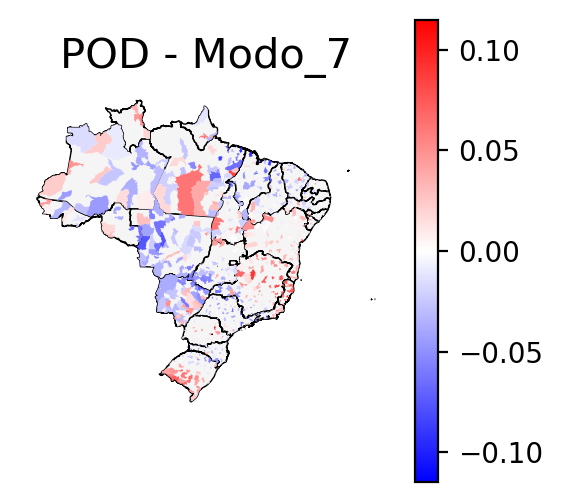

In [33]:
k = 7
%matplotlib inline
fig, ax = plt.subplots(ncols=1, nrows=1 ,figsize=(3,3),dpi=200)

UF.plot(facecolor="whitesmoke", edgecolor="black", ax=ax,lw=0.5)
v = max(np.abs(Cidades[f'Modo_{k}'].min()), np.abs(Cidades[f'Modo_{k}'].max())  )
Cidades.plot(ax=ax,column=f'Modo_{k}',cmap='bwr',legend=True,vmin=-v,vmax=v)

ax.set_title(f"POD - Modo_{k}", fontsize=15)
ax.axis("off")


### Substituindo dados faltantes por Interpolação entre Cidades 

In [38]:
#Compartilham index
Cidades_nan  = Cidades[pd.isnull(Cidades).any(axis=1)]
Cidades_real = Cidades[~pd.isnull(Cidades).any(axis=1)]

n = 2 # n=2 é o procedimento comum. Qto maior o valor 'n', menor a correlação a longa distnacia. 
for i in np.arange( len(Cidades_nan) ):
    idx   = Cidades_nan.index[i]
    point = Cidades_nan.loc[ idx, 'centroid'  ]

    d_inv = 1.0/( Cidades_real.distance(point)**n )
    for k in np.arange( len(Modos.columns) - 1 ):
        Cidades_nan.loc[idx, f'Modo_{k+1}'] = (d_inv*Cidades_real[f'Modo_{k+1}']).sum()/d_inv.sum()

Cidades_Full = pd.concat([Cidades_nan, Cidades_real ])

/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_2663/3337530466.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  d_inv = 1.0/( Cidades_real.distance(point)**n )
/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_2663/3337530466.py:12: RuntimeWarning: invalid value encountered in scalar divide
  Cidades_nan.loc[idx, f'Modo_{k+1}'] = (d_inv*Cidades_real[f'Modo_{k+1}']).sum()/d_inv.sum()


#### Visualizando

(-76.24759047174989, -26.590499411250004, -35.7023289475499, 7.222992030550026)

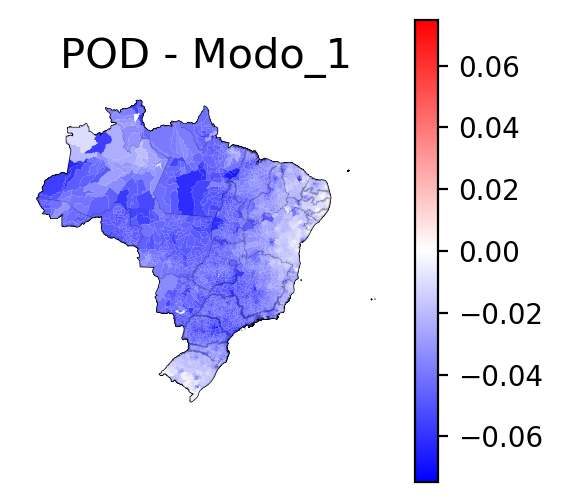

In [39]:

k = 1
%matplotlib inline
fig, ax = plt.subplots(ncols=1, nrows=1 ,figsize=(3,3),dpi=200)

UF.plot(facecolor="whitesmoke", edgecolor="black", ax=ax,lw=0.5)
v = max(np.abs(Cidades_Full[f'Modo_{k}'].min()), np.abs(Cidades_Full[f'Modo_{k}'].max())  )
Cidades_Full.plot(ax=ax,column=f'Modo_{k}',cmap='bwr',legend=True,vmin=-v,vmax=v)

ax.set_title(f"POD - Modo_{k}", fontsize=15)
ax.axis("off")


## Resultados

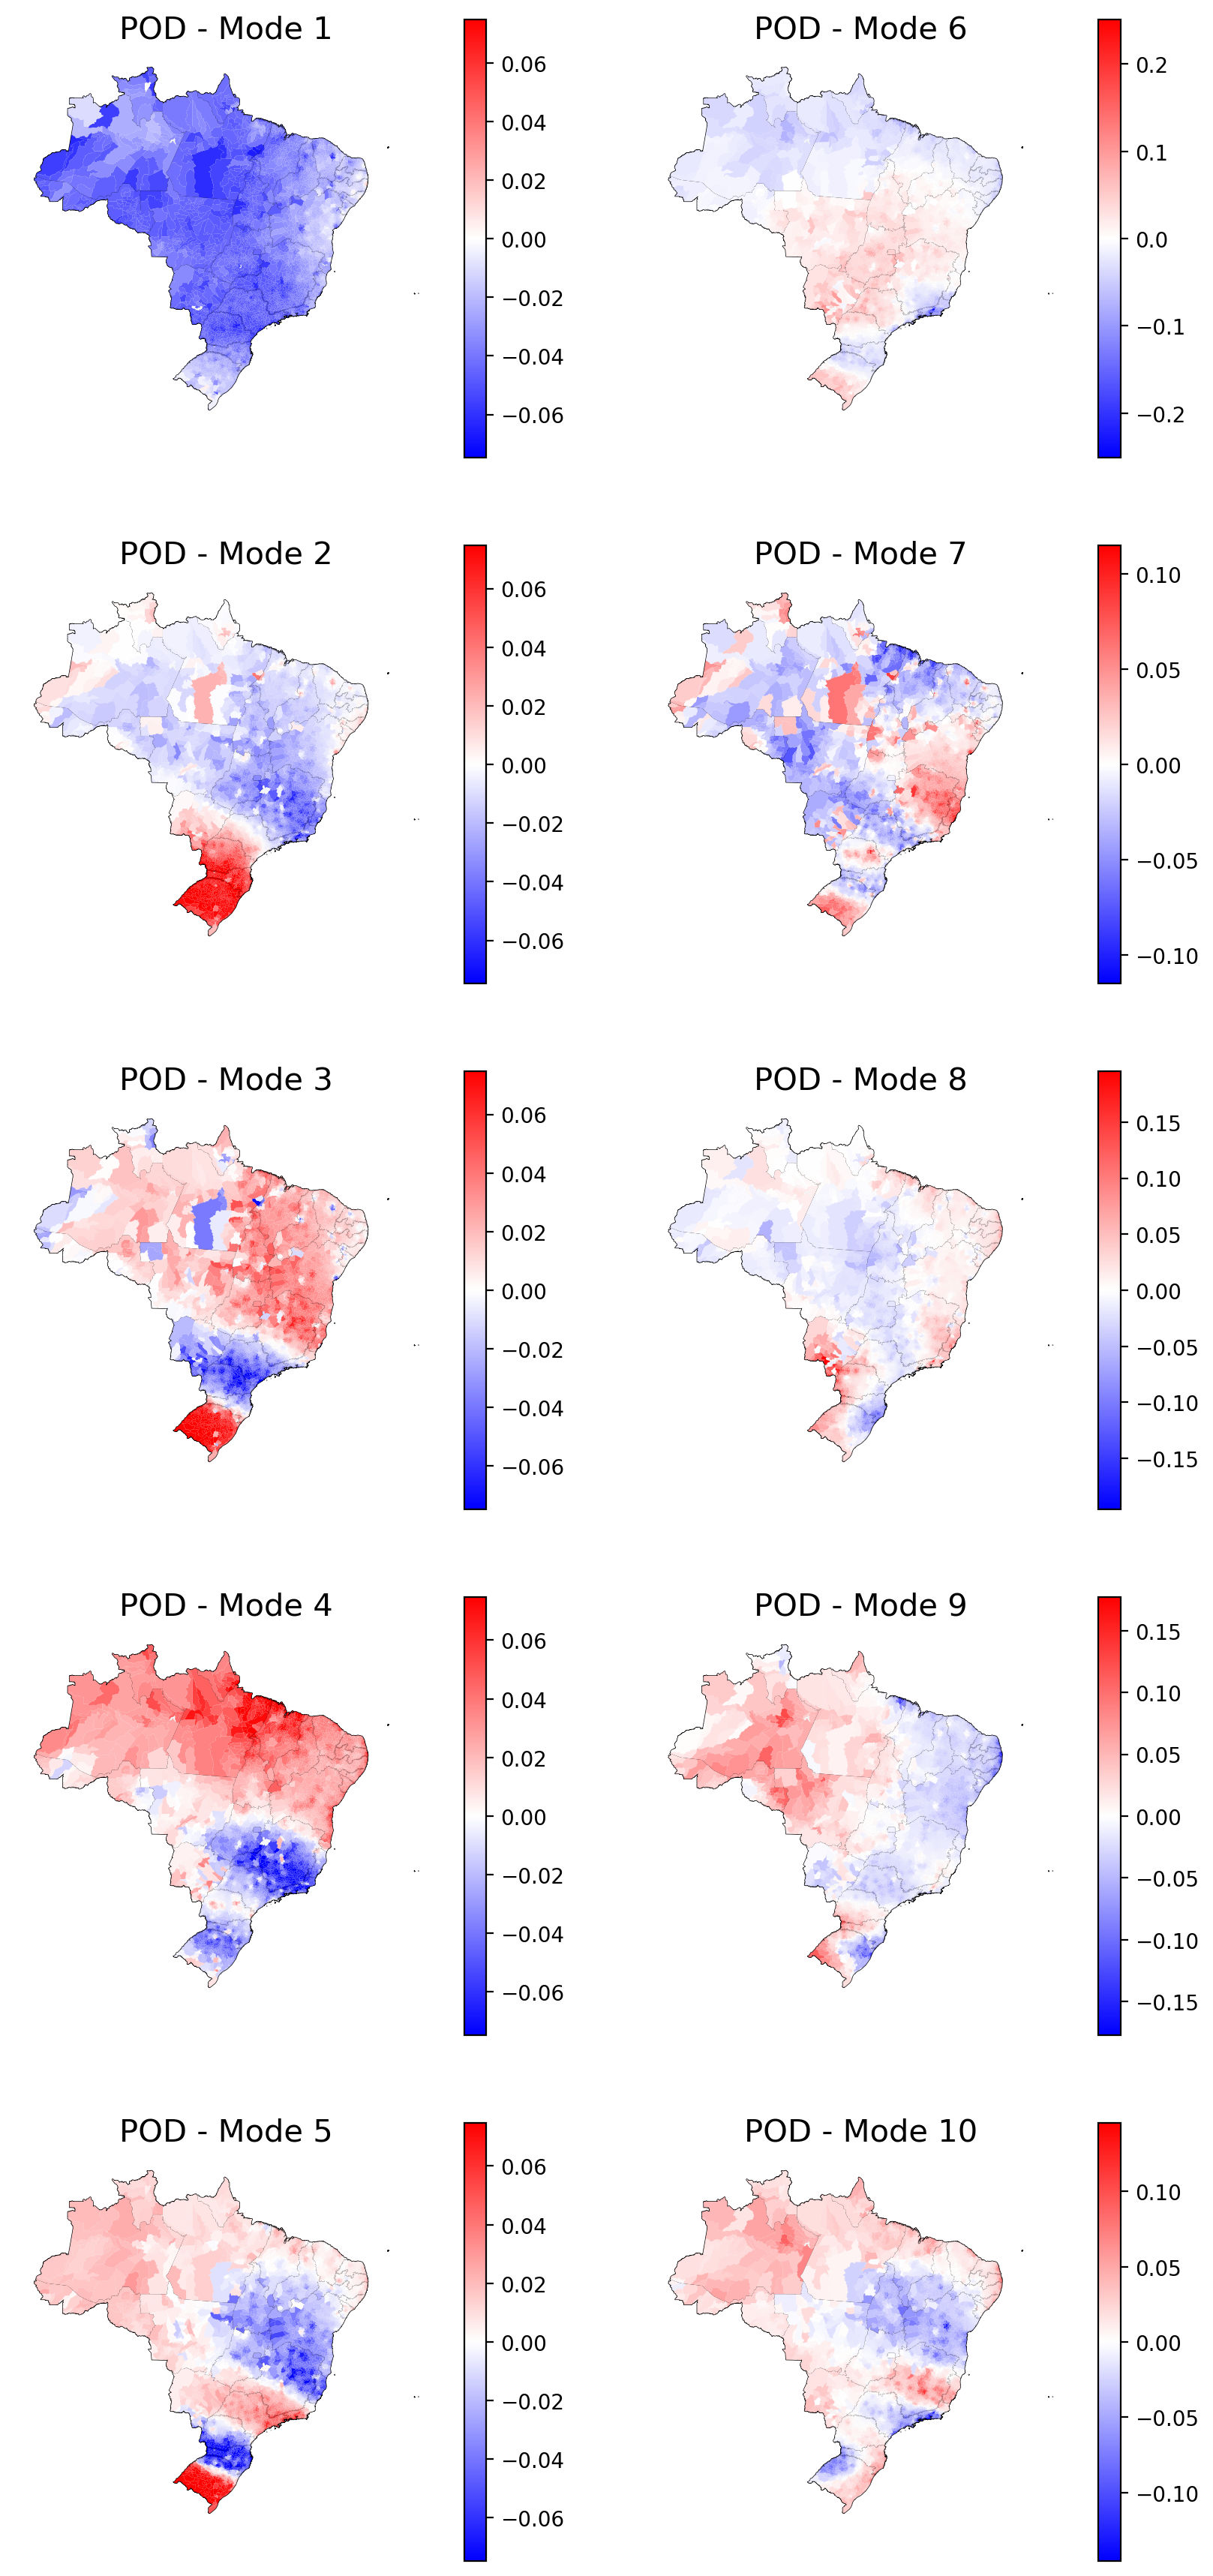

In [40]:
%matplotlib inline
fig, ax = plt.subplots(ncols=2, nrows=5 ,figsize=(10, 22),dpi=200)

for k in np.arange(5):          
    UF.plot(facecolor="whitesmoke", edgecolor="black", ax=ax[k,0],lw=0.5)
    Cidades_Full.plot(ax=ax[k,0],column=f"Modo_{k+1}",cmap='bwr',legend=True,vmin=-v,vmax=v)
    ax[k,0].set_title(f"POD - Mode {k+1}", fontsize=15)
    ax[k,0].axis("off")

for k in np.arange(5,10):          
    UF.plot(facecolor="whitesmoke", edgecolor="black", ax=ax[k-5,1],lw=0.5)
    v = max(np.abs(Cidades_Full[f'Modo_{k+1}'].min()), np.abs(Cidades_Full[f'Modo_{k+1}'].max())  )
    Cidades_Full.plot(ax=ax[k-5,1],column=f"Modo_{k+1}",cmap='bwr',legend=True,vmin=-v,vmax=v)
    ax[k-5,1].set_title(f"POD - Mode {k+1}", fontsize=15)
    ax[k-5,1].axis("off")

#plt.savefig('Modos.png')

### Resultados Por Estado

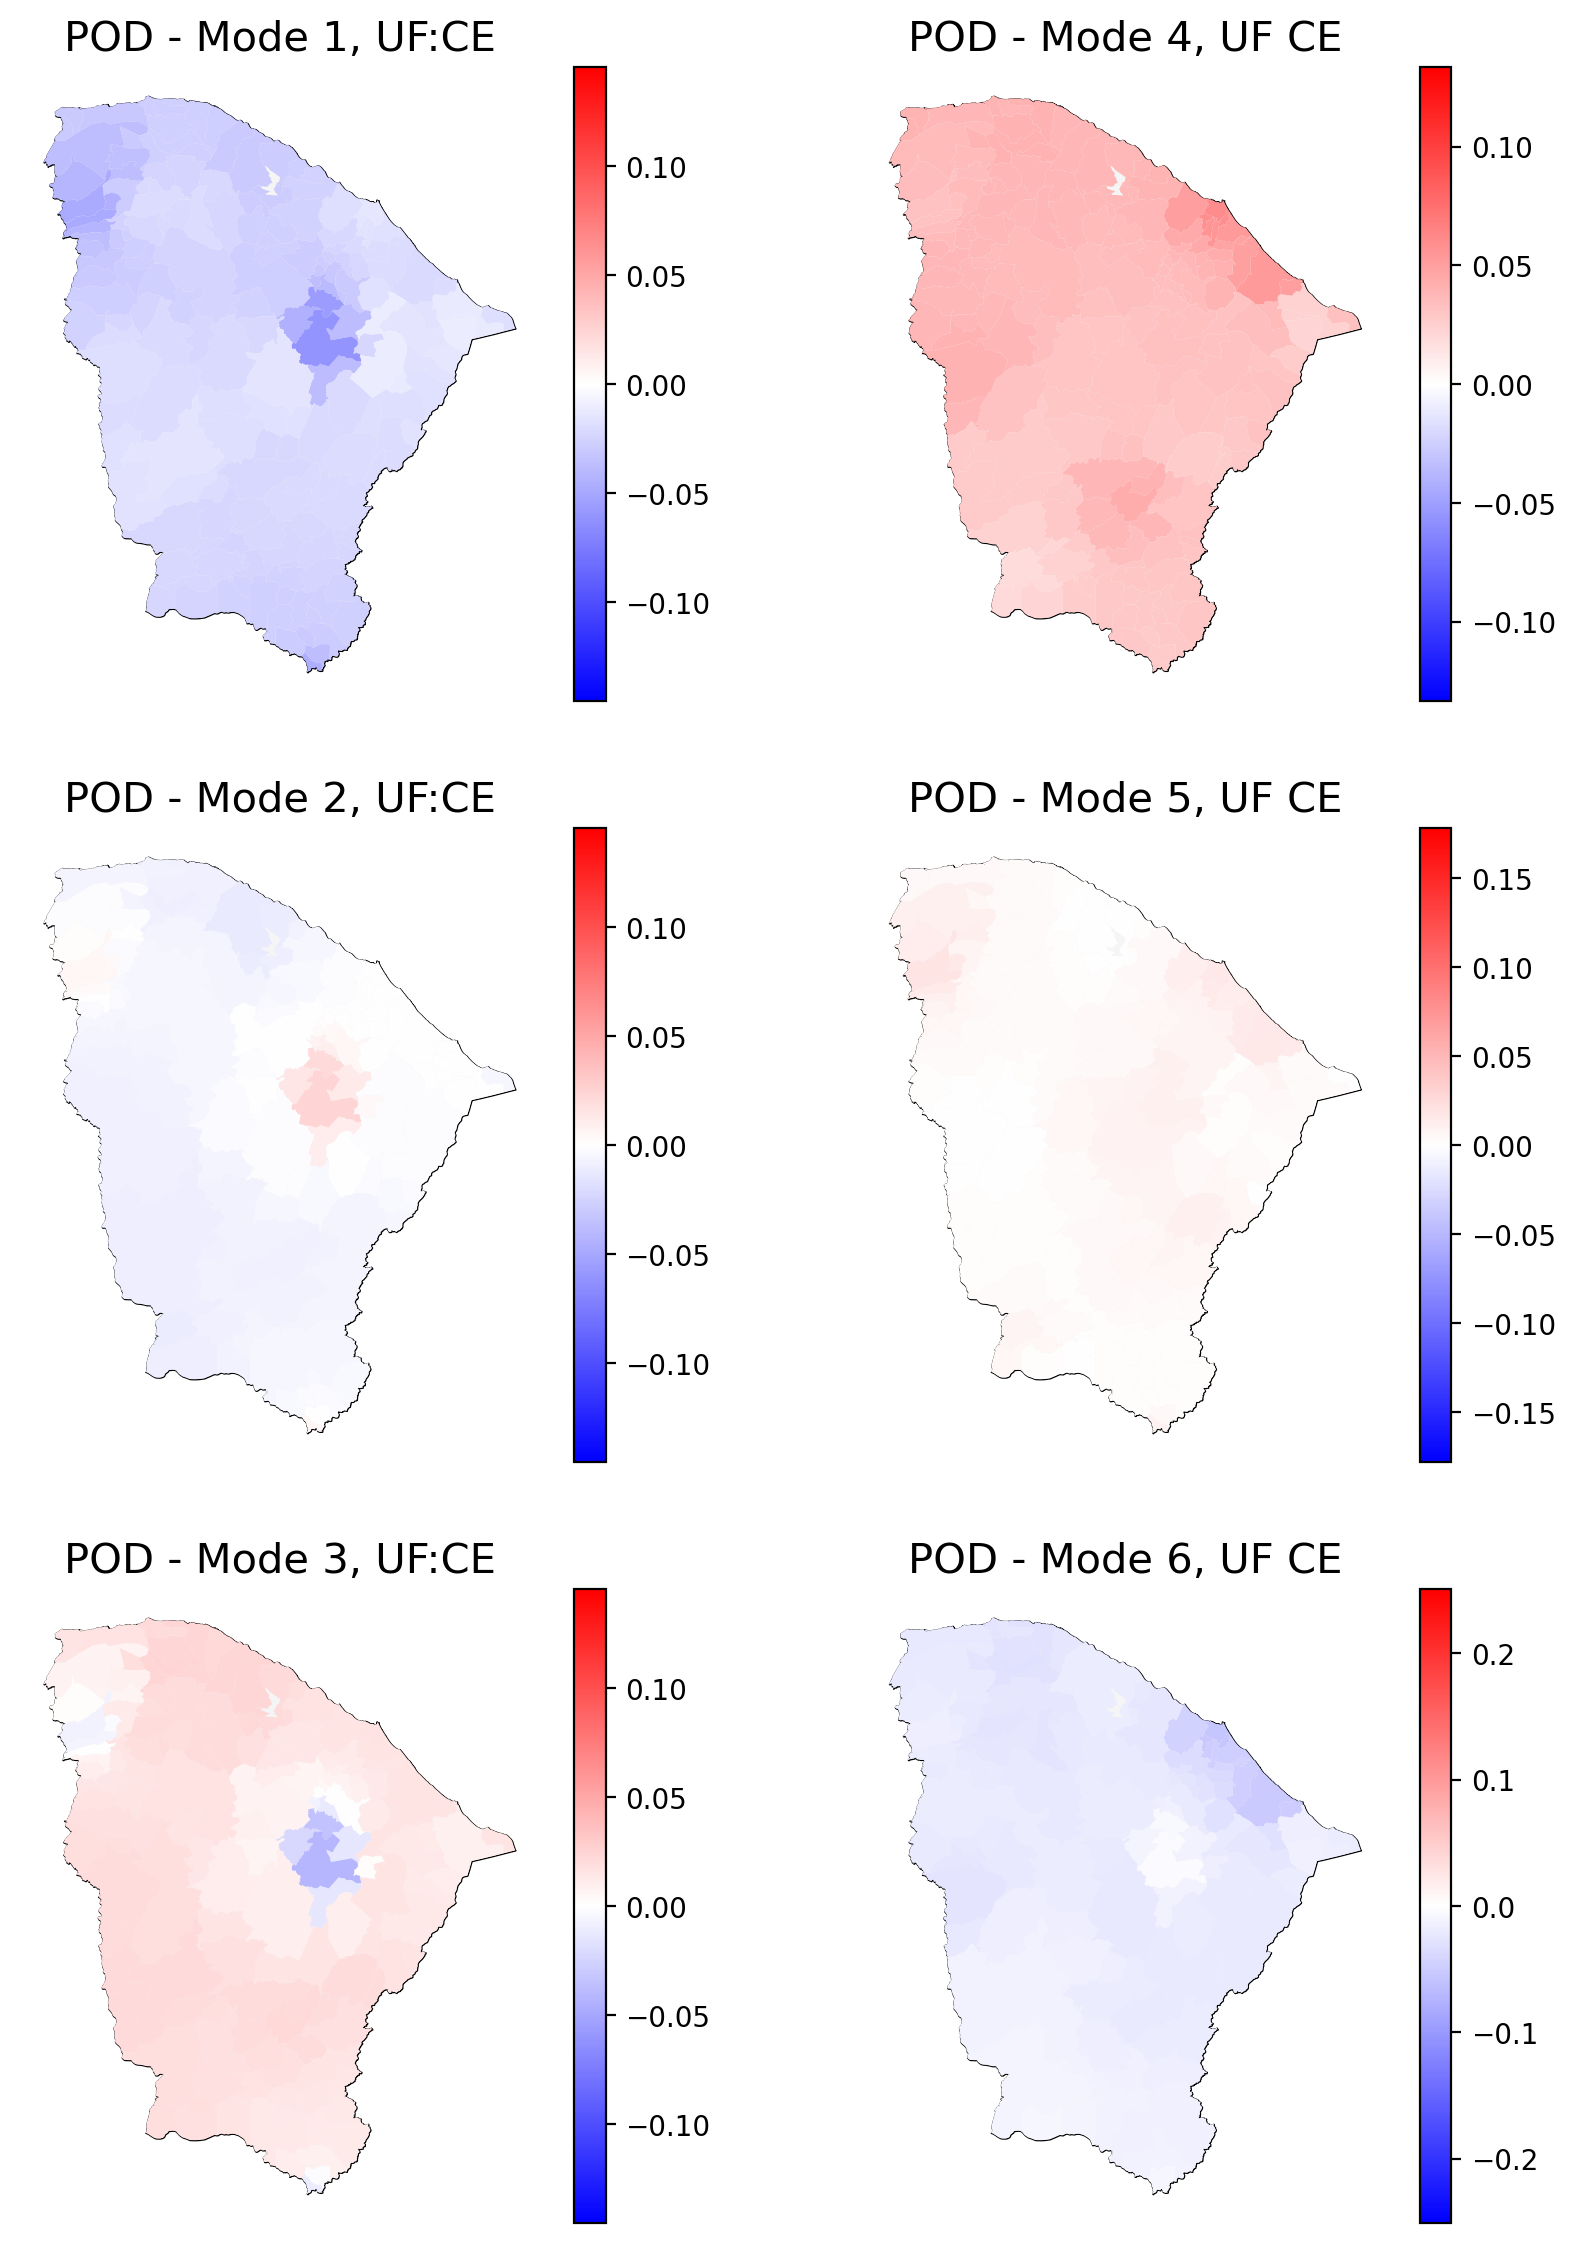

In [41]:
uf = 'CE'
%matplotlib inline
fig, ax = plt.subplots(ncols=2, nrows=3 ,figsize=(10, 14),dpi=200)

for k in np.arange(3):          
    UF.loc[(UF['SIGLA_UF']==uf)].plot(facecolor="whitesmoke", edgecolor="black", ax=ax[k,0],lw=0.5)
    Cidades_Full.loc[(Cidades_Full['SIGLA_UF']==uf)].plot(ax=ax[k,0],column=f"Modo_{k+1}",cmap='bwr',legend=True,vmin=-v,vmax=v)
    ax[k,0].set_title(f"POD - Mode {k+1}, UF:{uf}", fontsize=15)
    ax[k,0].axis("off")

for k in np.arange(3,6):          
    UF.loc[(UF['SIGLA_UF']==uf)].plot(facecolor="whitesmoke", edgecolor="black", ax=ax[k-3,1],lw=0.5)
    v = max(np.abs(Cidades_Full[f'Modo_{k+1}'].min()), np.abs(Cidades_Full[f'Modo_{k+1}'].max())  )
    Cidades_Full.loc[(Cidades_Full['SIGLA_UF']==uf)].plot(ax=ax[k-3,1],column=f"Modo_{k+1}",cmap='bwr',legend=True,vmin=-v,vmax=v)
    ax[k-3,1].set_title(f"POD - Mode {k+1}, UF {uf}", fontsize=15)
    ax[k-3,1].axis("off")

#plt.savefig('Modos.png')